In [143]:
import geopandas as gpd
from shapely.geometry import box, Point
import pandas as pd
import rasterio as rio
import glob
import os

In [139]:
with rio.open("preprocessing_data/8bit/patched_full/patched_full.27.tif") as src:
    profile = src.profile

In [140]:
df = pd.read_csv("results/txt/patched_full.27.txt", delimiter = " ", names = ['class', 'x', 'y', 'width', 'height'])

FileNotFoundError: [Errno 2] No such file or directory: '27.txt'

In [129]:
df['x'] = round(df.x * 256)
df['y'] = round(df.y * 256)

In [130]:
df['centroid'] = df.apply(lambda row: Point(profile['transform'] * (row.x, row.y)), axis = 1)

In [131]:
df['centroid']

0      POINT (-3.983078179938917 5.409753955519084)
1      POINT (-4.210557668305342 5.147190565961817)
2       POINT (-4.03287468485495 5.166430124679375)
3      POINT (-4.105305964732817 5.146058827213725)
4      POINT (-4.069090324793883 5.146058827213725)
                          ...                      
81    POINT (-4.159629424641217 5.4074904780229005)
82     POINT (-4.0713538022900675 5.40070004553435)
83     POINT (-4.159629424641217 5.365616144343509)
84    POINT (-4.211689407053433 5.1675618634274665)
85    POINT (-4.0871981447633505 5.220753584587775)
Name: centroid, Length: 86, dtype: object

In [132]:
df 

,class,x,y,width,height,centroid
0,0,58880.0,1792.0,0.083171,0.057803,POINT (-3.983078179938917 5.409753955519084)
1,0,7424.0,61184.0,0.075959,0.077730,POINT (-4.210557668305342 5.147190565961817)
2,0,47616.0,56832.0,0.074955,0.074330,POINT (-4.03287468485495 5.166430124679375)
3,0,31232.0,61440.0,0.072025,0.072131,POINT (-4.105305964732817 5.146058827213725)
4,0,39424.0,61440.0,0.073631,0.072420,POINT (-4.069090324793883 5.146058827213725)
...,...,...,...,...,...,...
81,0,18944.0,2304.0,0.069778,0.065696,POINT (-4.159629424641217 5.4074904780229005)
82,0,38912.0,3840.0,0.084126,0.077278,POINT (-4.0713538022900675 5.40070004553435)
83,0,18944.0,11776.0,0.077150,0.075033,POINT (-4.159629424641217 5.365616144343509)
84,0,7168.0,56576.0,0.075013,0.076750,POINT (-4.211689407053433 5.1675618634274665)


In [133]:
gdf = gpd.GeoDataFrame(geometry = df['centroid'])

<Axes: >

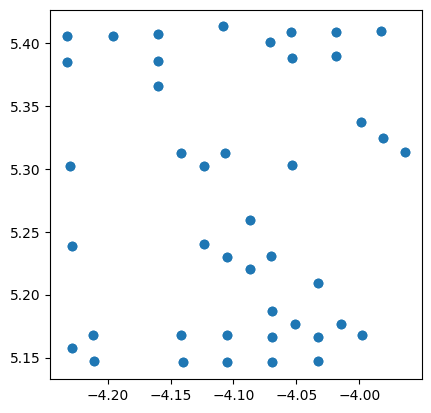

In [134]:
gdf.plot()

In [135]:
buffer_x = 0.00005
buffer_y = 0.00005

In [136]:
def point_to_bbox(geom, buffer_x, buffer_y):
    minx, miny = geom.x - buffer_x, geom.y - buffer_y
    maxx, maxy = geom.x + buffer_x, geom.y + buffer_y
    return box(minx, miny, maxx, maxy)

# Apply the function to each point geometry
gdf['bbox'] = gdf.geometry.apply(lambda geom: point_to_bbox(geom, buffer_x, buffer_y))

# Set bbox as the new geometry column, if needed
gdf = gdf.set_geometry('bbox')

# Display the resulting GeoDataFrame with bounding boxes
print(gdf.head())

                   geometry                                               bbox
0  POINT (-3.98308 5.40975)  POLYGON ((-3.98303 5.40970, -3.98303 5.40980, ...
1  POINT (-4.21056 5.14719)  POLYGON ((-4.21051 5.14714, -4.21051 5.14724, ...
2  POINT (-4.03287 5.16643)  POLYGON ((-4.03282 5.16638, -4.03282 5.16648, ...
3  POINT (-4.10531 5.14606)  POLYGON ((-4.10526 5.14601, -4.10526 5.14611, ...
4  POINT (-4.06909 5.14606)  POLYGON ((-4.06904 5.14601, -4.06904 5.14611, ...


<Axes: >

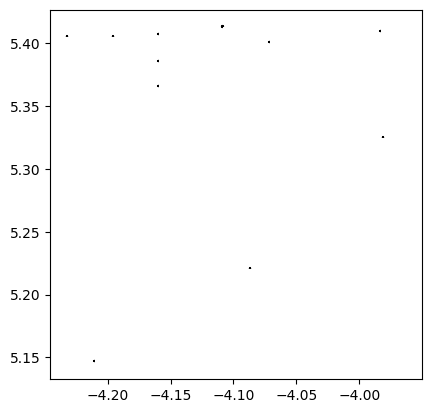

In [138]:
gdf.boundary.plot(color='k')

In [116]:
gdf.to_file('59.shp', driver="ESRI Shapefile")

# Automation

In [144]:
def point_to_bbox(geom, buffer_x, buffer_y):
    minx, miny = geom.x - buffer_x, geom.y - buffer_y
    maxx, maxy = geom.x + buffer_x, geom.y + buffer_y
    return box(minx, miny, maxx, maxy)

In [160]:
buffer_x = 0.00005
buffer_y = 0.00005
for i in glob.glob("results/*.txt"):
    file_name = os.path.splitext(os.path.split(i)[1])[0]
    
    with rio.open(f"preprocessing_data/8bit/patched_full/{file_name}.tif") as src:
        profile = src.profile
    
    df = pd.read_csv(f"results/{file_name}.txt", delimiter = " ", names = ['class', 'x', 'y', 'width', 'height'])  
    df['x'] = round(df.x * 256)
    df['y'] = round(df.y * 256)
    df['centroid'] = df.apply(lambda row: Point(profile['transform'] * (row.x, row.y)), axis = 1)
    gdf = gpd.GeoDataFrame(geometry = df['centroid'])
    gdf['geometry'] = gdf.geometry.apply(lambda geom: point_to_bbox(geom, buffer_x, buffer_y))
    gdf.to_file(f'results/shp/{file_name}.shp', driver="ESRI Shapefile", ignore_index=True)

# Concatenation

In [161]:
df = None
for i in glob.glob("results/shp/*.shp"):
    df_curr = gpd.read_file(i, index = False)
    if df is None:
        df = df_curr
    else:
        df = pd.concat([df, df_curr], ignore_index = True)
    

In [162]:
df # So we have recognized a total of 10008 palm trees!

,FID,geometry
0,0,"POLYGON ((-4.23660 5.41735, -4.23670 5.41735, ..."
1,1,"POLYGON ((-4.23717 5.41734, -4.23727 5.41734, ..."
2,2,"POLYGON ((-4.23709 5.41674, -4.23719 5.41674, ..."
3,3,"POLYGON ((-4.23688 5.41670, -4.23698 5.41670, ..."
4,4,"POLYGON ((-4.23731 5.41693, -4.23741 5.41693, ..."
...,...,...
10003,213,"POLYGON ((-4.24117 5.41725, -4.24127 5.41725, ..."
10004,0,"POLYGON ((-4.23366 5.41947, -4.23376 5.41947, ..."
10005,1,"POLYGON ((-4.23354 5.41957, -4.23364 5.41957, ..."
10006,2,"POLYGON ((-4.23350 5.41939, -4.23360 5.41939, ..."


In [163]:
gdf = gpd.GeoDataFrame(df)

<Axes: >

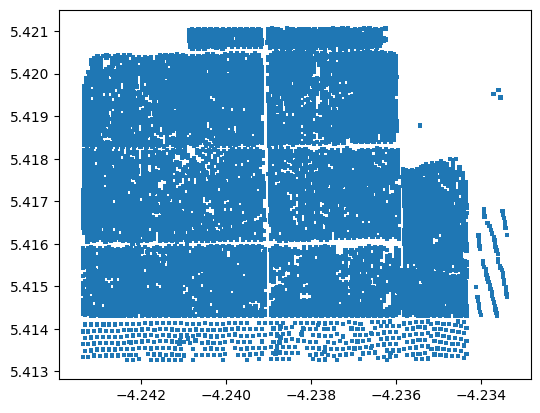

In [164]:
gdf.plot()

# Cleaning out of bounds predictions

In [171]:
with rio.open("/Users/nischalsingh/projects/ultralytics/preprocessing_data/8bit/oil_palm_8bit.tif") as src:
    data_bounds = src.bounds

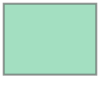

In [172]:
data_extent = box(data_bounds.left, data_bounds.bottom, data_bounds.right, data_bounds.top)
data_extent

In [173]:
filtered_polygons = gdf[gdf.geometry.intersects(data_extent)]
filtered_polygons

,FID,geometry
0,0,"POLYGON ((-4.23660 5.41735, -4.23670 5.41735, ..."
1,1,"POLYGON ((-4.23717 5.41734, -4.23727 5.41734, ..."
2,2,"POLYGON ((-4.23709 5.41674, -4.23719 5.41674, ..."
3,3,"POLYGON ((-4.23688 5.41670, -4.23698 5.41670, ..."
4,4,"POLYGON ((-4.23731 5.41693, -4.23741 5.41693, ..."
...,...,...
9999,209,"POLYGON ((-4.24159 5.41699, -4.24169 5.41699, ..."
10000,210,"POLYGON ((-4.24195 5.41651, -4.24205 5.41651, ..."
10001,211,"POLYGON ((-4.24138 5.41730, -4.24148 5.41730, ..."
10002,212,"POLYGON ((-4.24125 5.41761, -4.24135 5.41761, ..."


### We have identified a total of 10003 Palm Trees!

In [176]:
filtered_polygons.to_file("results/prediction.shp", driver="ESRI Shapefile")